# **Configuration**

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

def configure_gpu(device_id: str = "0") -> None:
    """
    Configures the GPU for TensorFlow usage.

    Parameters:
    - device_id (str): The GPU device ID to use. Default is "0".

    Returns:
    - None: Prints TensorFlow version and GPU availability.
    """
    os.environ["CUDA_VISIBLE_DEVICES"] = device_id

    print(f'TensorFlow Version: {tf.__version__}')

    if tf.config.list_physical_devices('GPU'):
        print('GPU detected and configured!')
    else:
        print('No GPU found, using CPU.')

def set_random_seed(seed_value: int = 42) -> None:
    """
    Sets a fixed seed for random number generation to ensure reproducibility.

    Parameters:
    - seed_value (int): The seed value to set. Default is 42.

    Returns:
    - None: Prints confirmation of seed initialization.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    print(f'Random seed initialized to {seed_value}.')

# Initialize seed and device configuration
set_random_seed()
configure_gpu()

Done!


# **Import**

In [3]:
import math
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from ssqueezepy import ssq_stft
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from livelossplot.inputs.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# **Initialization**

In [4]:
# Auto-tuning for dataset performance optimization
AUTO_TUNE = tf.data.AUTOTUNE  

# Training parameters
NUM_EPOCHS = 15
BATCH_SIZE = 32
NUM_CLASSES = 5

# Input data dimensions
SIGNAL_SHAPE = (3000,)  # Shape of the EEG signal input
IMAGE_SHAPE = (12, 128, 256, 1)  # Shape of the transformed image representation

# Overlapping factor for windowing EEG signals
OVERLAP = 7  

# Optimizer and training hyperparameters
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5

# Optimizer
optimizer = tf.keras.optimizers.legacy.Adamax(learning_rate=LEARNING_RATE)

# Loss function for multi-class classification
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Metrics to monitor during training
metrics = ['accuracy']

# Transformer model hyperparameters (if applicable)
NUM_LAYERS = 8  # Number of transformer layers
NUM_HEADS = 8  # Attention heads
PROJECTION_DIM = 128  # Projection dimension for attention mechanism
LAYER_NORM_EPSILON = 1e-6  # Small constant for numerical stability

# Patch-based processing for transformer models
PATCH_SIZE = (8, 8, 8)  # Patch size for dividing input data
NUM_PATCHES = (IMAGE_SHAPE[0] // PATCH_SIZE[0]) ** 2  # Number of patches per dimension

# **Data Loader**

In [ ]:
X_train = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")
X_val = pd.read_csv("validation.csv")

len_tr = len(X_train)
len_ts = len(X_test)
len_vl = len(X_val)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Custom data generator for EEG signal classification.

    This generator processes EEG signals, applies windowing, 
    performs time-frequency transformation, and prepares batches for training.

    Parameters:
    - data (pd.DataFrame): Input dataset containing EEG signals.
    - signal_shape (tuple): Shape of the EEG signal (e.g., (3000,)).
    - image_shape (tuple): Shape of the transformed image (e.g., (12, 128, 256, 1)).
    - batch_size (int): Number of samples per batch.
    - num_classes (int): Number of classification categories.
    - overlap (int): Overlap in signal windowing.
    """

    def __init__(self, data: pd.DataFrame, signal_shape: tuple, image_shape: tuple,
                 batch_size: int, num_classes: int, overlap: int):
        self.data = data  # Pandas DataFrame with signal and labels
        self.signal_shape = signal_shape  # Shape of the input EEG signal
        self.image_shape = image_shape  # Shape of the transformed spectrogram/image
        self.batch_size = batch_size  # Number of samples per batch
        self.num_classes = num_classes  # Number of classification labels
        self.overlap = overlap  # Overlapping window size

        self.width = image_shape[2]  # Width of spectrogram/image
        self.step_size = self.width - overlap  # Step size for windowing
        self.num_windows = math.floor((signal_shape[0] - overlap) / self.step_size)  # Number of windows

        self.indexes = np.arange(len(self.data))  # Indexing for shuffling
        self.on_epoch_end()  # Initialize index shuffling

    def __len__(self) -> int:
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index: int):
        """
        Retrieves a batch of data.

        Parameters:
        - index (int): Batch index.

        Returns:
        - x (np.ndarray): EEG signals transformed into images.
        - y (np.ndarray): One-hot encoded labels.
        """
        # Select indexes for the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.data.iloc[k] for k in indexes]

        x, y = self.__data_generation(batch_data)
        return x, y

    def on_epoch_end(self):
        """Shuffles data indices at the end of each epoch."""
        np.random.shuffle(self.indexes)

    def window_signal(self, signal: np.ndarray) -> list:
        """
        Splits a signal into overlapping windows.

        Parameters:
        - signal (np.ndarray): 1D EEG signal array.

        Returns:
        - list: List of windowed signal segments.
        """
        return [signal[self.step_size * j: self.width + self.step_size * j] for j in range(self.num_windows)]

    def __data_generation(self, batch_data: list):
        """
        Generates transformed EEG images and corresponding labels.

        Parameters:
        - batch_data (list): List of samples from the dataset.

        Returns:
        - x (np.ndarray): Transformed spectrograms.
        - y (np.ndarray): One-hot encoded labels.
        """
        x = np.empty((self.batch_size, *self.image_shape))
        y = np.empty((self.batch_size), dtype=int)

        for i, sample in enumerate(batch_data):
            try:
                # Extract signal and label
                signal = np.array(sample[1:3001]).reshape(*self.signal_shape)
                y[i] = int(sample[3001])  # Class label

                # Apply windowing
                windowed_signals = self.window_signal(signal)

                for k, windowed_signal in enumerate(windowed_signals):
                    _, TF, *_ = ssq_stft(windowed_signal.flatten())  # Time-frequency transform
                    spectrogram = np.abs(TF)[:self.image_shape[1], :self.image_shape[2]]

                    # Normalize the spectrogram
                    x[i, k, :, :, 0] = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())

            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                continue  # Skip corrupted samples

        return x, to_categorical(y, num_classes=self.num_classes)


# Initialize data generators
train_gen = DataGenerator(X_train, SIGNAL_SHAPE, IMAGE_SHAPE, BATCH_SIZE, NUM_CLASSES, OVERLAP)
test_gen = DataGenerator(X_test, SIGNAL_SHAPE, IMAGE_SHAPE, BATCH_SIZE, NUM_CLASSES, OVERLAP)
val_gen = DataGenerator(X_val, SIGNAL_SHAPE, IMAGE_SHAPE, BATCH_SIZE, NUM_CLASSES, OVERLAP)

C:\Users\USER\AppData\Local\Temp\ipykernel_3096\3641421541.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y[i] = int(ID[3001])


The label is:  [1. 0. 0. 0. 0.]
The shape of the data is:  (12, 128, 256, 1)
The minimum of the data is:  0.0
The maximum of the data is:  1.0

The input data is: 



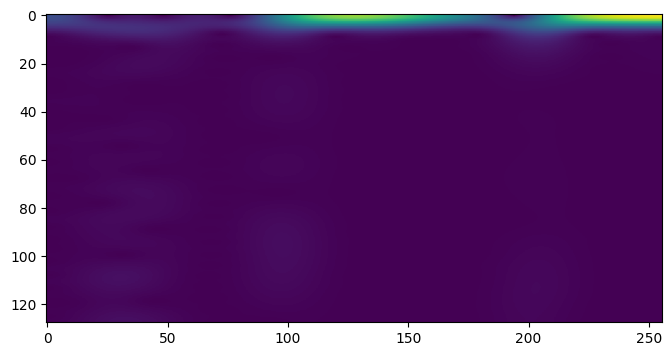

In [7]:
# Extract a sample from the validation generator
data_sample = next(iter(val_gen))

# Unpacking data and labels
x_sample, y_sample = data_sample

# Display label and data properties
print('The label (one-hot):', y_sample[0])  # Print one-hot encoded label
print('Decoded label:', np.argmax(y_sample[0]))  # Print class index
print('Shape of the input data:', x_sample[0].shape)
print('Min value of data:', x_sample[0].min())
print('Max value of data:', x_sample[0].max())

# Display an image from the first window
plt.figure(figsize=(8, 4))
plt.imshow(x_sample[0][0, :, :, 0], cmap='gray')  # Select first window and remove channel dimension
plt.title(f'EEG Spectrogram - Label: {np.argmax(y_sample[0])}')
plt.colorbar()
plt.show()

In [8]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = np.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


def create_vivit_classifier(
        tubelet_embedder,
        positional_encoder,
        input_shape=IMAGE_SHAPE,
        transformer_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        embed_dim=PROJECTION_DIM,
        layer_norm_eps=LAYER_NORM_EPSILON,
        num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = tf.keras.Sequential(
            [
                layers.Dense(units=embed_dim * 8, activation=tf.keras.activations.gelu),
                # Increase the first layer's size
                layers.Dense(units=embed_dim * 4, activation=tf.keras.activations.gelu),  # Adjust subsequent layers
                layers.Dense(units=embed_dim, activation=tf.keras.activations.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    normalized_representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation_avg = layers.GlobalAvgPool1D()(normalized_representation)
    representation_max = layers.GlobalMaxPool1D()(normalized_representation)
    representation = layers.Concatenate()([representation_avg, representation_max])

    x_img = layers.Dense(64)(representation)

    # Classify outputs.
    fc = layers.Dense(units=32)(x_img)
    fc = layers.Dense(units=num_classes)(fc)
    outputs = layers.Softmax()(fc)

    # Create the Keras model.
    return Model(inputs=inputs, outputs=outputs)


model = create_vivit_classifier(tubelet_embedder=TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE),
                                positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM))
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 128, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 tubelet_embedding (TubeletEmbe  (None, 512, 128)    65664       ['input_1[0][0]']                
 dding)                                                                                           
                                                                                                  
 positional_encoder (Positional  (None, 512, 128)    65536       ['tubelet_embedding[0][0]']      
 Encoder)                                                                                     

# **Train**

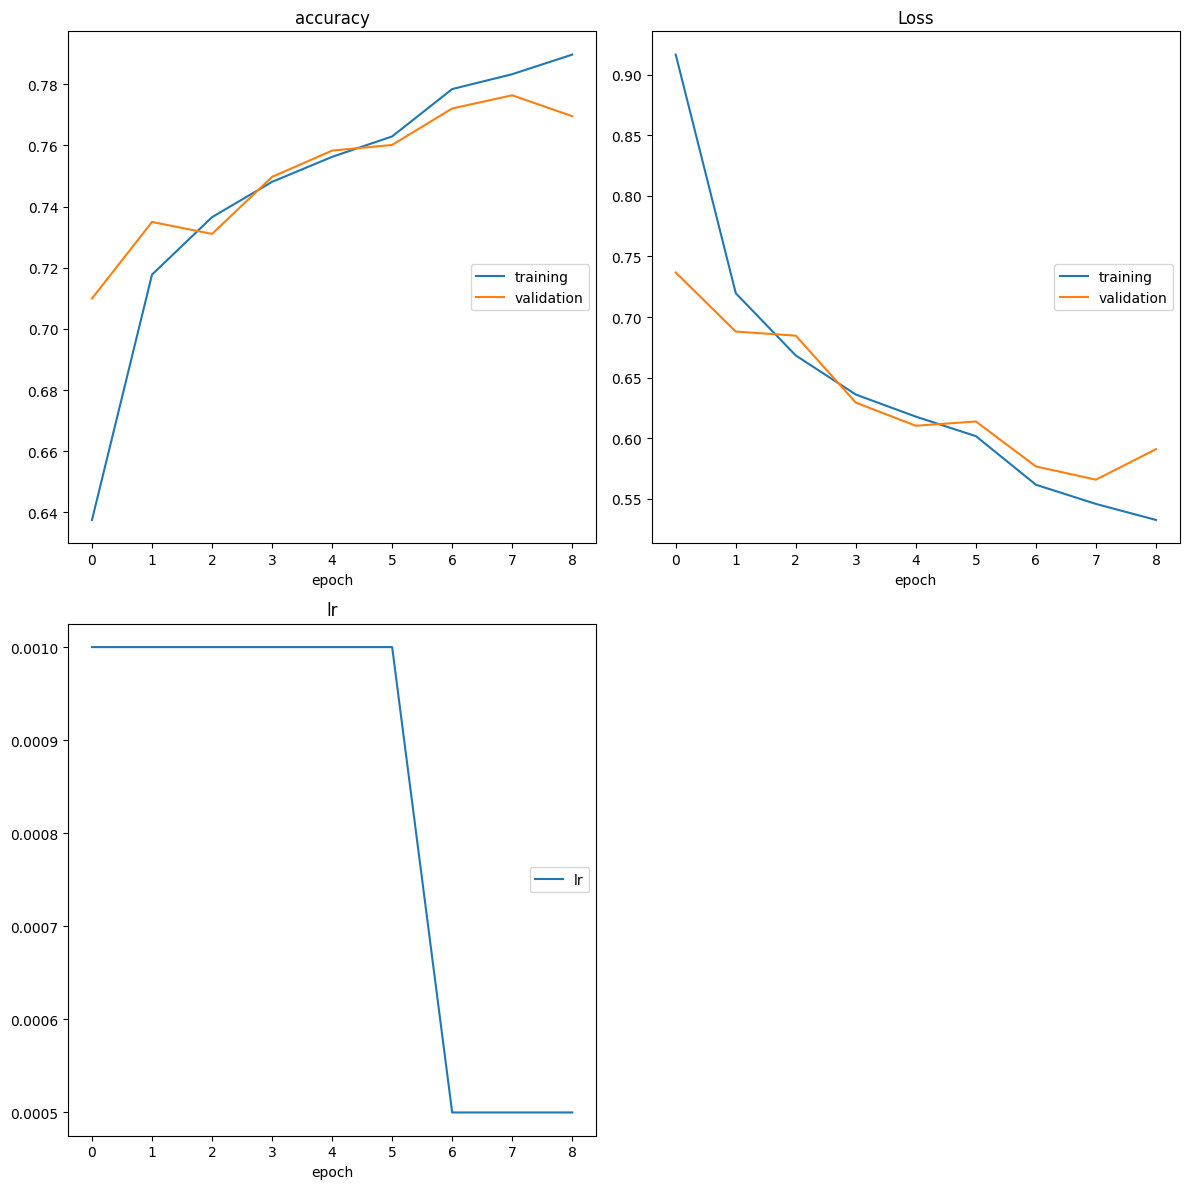

accuracy
	training         	 (min:    0.638, max:    0.790, cur:    0.790)
	validation       	 (min:    0.710, max:    0.776, cur:    0.770)
Loss
	training         	 (min:    0.533, max:    0.916, cur:    0.533)
	validation       	 (min:    0.566, max:    0.737, cur:    0.591)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
4866/4866 [==============================] - 7503s 2s/step - loss: 0.5326 - accuracy: 0.7897 - val_loss: 0.5910 - val_accuracy: 0.7696 - lr: 5.0000e-04
Epoch 10/15
4866/4866 [==============================] - ETA: 0s - loss: 0.4987 - accuracy: 0.8029

In [ ]:
def get_callbacks():
    """
    Returns a list of callbacks for training.

    - ModelCheckpoint: Saves the best model based on validation loss.
    - ReduceLROnPlateau: Reduces learning rate if validation loss plateaus.
    - PlotLossesCallback: Live loss visualization.

    Returns:
        list: List of callbacks.
    """
    checkpoint = ModelCheckpoint(filepath="../models/simple_vivit.tf",
                                 monitor='val_loss',
                                 mode='min',
                                 verbose=1,
                                 save_best_only=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,
                                  patience=1,
                                  min_lr=1e-5,
                                  verbose=1)

    plot_losses = PlotLossesCallback()

    return [checkpoint, reduce_lr, plot_losses]


history = model.fit(train_gen,
                    validation_data=val_gen,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    callbacks=get_callbacks(),
                    steps_per_epoch=len_tr // BATCH_SIZE,
                    validation_steps=len_vl // BATCH_SIZE)

# **Evaluation**

In [ ]:
# Load model
testmodel = tf.keras.models.load_model("../models/simple_vivit.tf")

def windowing(signal):
    width = IMAGE_SHAPE[2]
    diff = width - OVERLAP
    n = math.floor((SIGNAL_SHAPE[0] - OVERLAP) / diff)

    return [signal[diff * j: width + diff * j] for j in range(n)]

y_true, y_pred = [], []

for i, ID in tqdm(X_test.iterrows(), total=len(X_test)):  # Fix tqdm with iterrows
    sig = np.array(ID[1:3001]).reshape(*SIGNAL_SHAPE)
    all_sig = windowing(sig)
    
    x = np.empty((1, *IMAGE_SHAPE))  # Move this inside the loop
    
    for k, windowed_sig in enumerate(all_sig):
        _, TF, *_ = ssq_stft(windowed_sig.flatten())
        v = np.abs(TF)[:IMAGE_SHAPE[1], :IMAGE_SHAPE[2]]

        # Avoid division by zero
        v_range = v.max() - v.min()
        x[0, k, :, :, 0] = (v - v.min()) / v_range if v_range > 0 else 0

    y_prob = testmodel.predict(x, verbose=0)
    y_pred.append(int(np.argmax(y_prob, axis=1)))
    y_true.append(int(ID[3001]))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['WAKE', 'N1', 'N2', 'N3', 'REM']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Sleep Stage Classification')
plt.show()

# Compute class-wise accuracy
class_accuracies = {}
for i, class_name in enumerate(class_names):
    TP = conf_matrix[i, i]  # True Positives
    FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives
    class_accuracies[class_name] = TP / (TP + FN) if (TP + FN) > 0 else 0

# Print class-wise accuracy
accuracy_df = pd.DataFrame(list(class_accuracies.items()), columns=['Class', 'Accuracy'])
print("\nClass-wise Accuracy:")
print(accuracy_df)

# Plot class-wise accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.ylim(0, 1)
plt.show()

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))